ERROR:root:Unable to open file: C:\Users\Santiago\Desktop\MiniProyecto\VTK\Placas\FDM.vtk
C:\Users\Santiago\AppData\Roaming\Python\Python311\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

Please install pythreejs to use this feature

Falling back to a static output.
  warnings.warn(


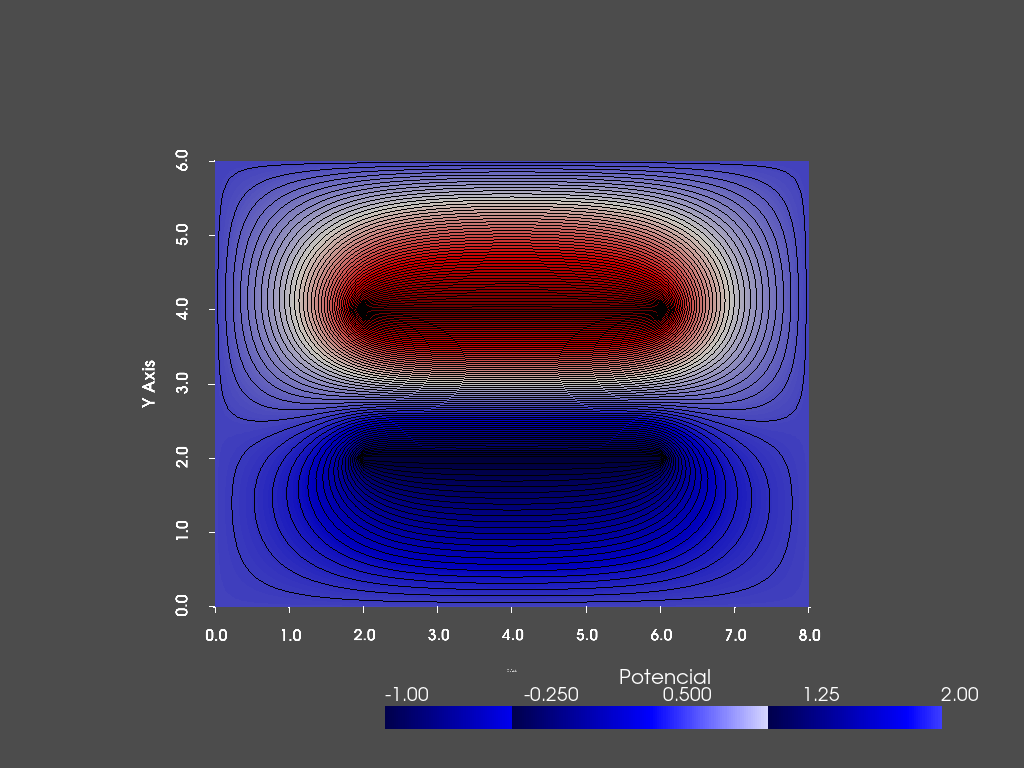

In [2]:
import pyvista as pv
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import numpy as np
c = 20
nx = 4*c #multiplo de 4
ny = 3*(c-5) #multiplo de 3

dx = 8/nx
dy = 6/ny

vt =  2
vb =  -1

data = []
row = []
col = []

ia = int(2/dx)
ib = int(6/dx)

jt = int(4/dy)
jb = int(2/dy)

nk = (nx + 1)*(ny + 1)
b = np.zeros(nk)

alpha = dy/dx
for k in range(nk):
    i = k%(nx+1)
    j = int(k/(nx+1))
    
    ### Fronteras superior o inferior
    if j==0 or j==ny:
        data.append(1)
        row.append(k)
        col.append(k)
        continue
    
    ### Fronteras laterales
    if i==0 or i==nx:
        data.append(1)
        row.append(k)
        col.append(k)
        continue
    
    ### Plato superior del capacitor
    if j==jt and (ia <= i <= ib):
        data.append(1)
        row.append(k)
        col.append(k)
        b[k] = vt
        continue

    ### Plato inferior del capacitor
    if j==jb and (ia <= i <= ib):
        data.append(1)
        row.append(k)
        col.append(k)
        b[k] = vb
        continue
    
    ### Derecha o izquierda
    J = j
    for di in [-1, 1]:
        I = i + di
        K = (nx+1)*J + I
        data.append( alpha**2)
        row.append(k)
        col.append(K)
        
    ### Arriba o abajo
    I = i
    for dj in [-1, 1]:
        J = j + dj
        K = (nx+1)*J + I
        data.append(1)
        row.append(k)
        col.append(K)
        
    ### Central
    # val = -2*( dx**2 + dy**2 )
    val = -2*( 1 + alpha**2 )
    data.append( val )
    row.append(k)
    col.append(k)
    
A = csr_matrix((data, (row, col)), shape=(nk, nk))
V = spsolve(A,b)

x = np.linspace(0, 8, nx+1)
y = np.linspace(0, 6, ny+1)
# x, y = np.meshgrid(x,y)

points = []

for j in range(ny+1):
    for i in range(nx+1):
        k = (nx+1)*j + i
        pt = ( x[i], y[j], 0*V[k] )
        points.append(pt)

points = np.array(points)
grid = pv.StructuredGrid()
grid.points = points
grid.point_data["Potencial"] = V
grid.dimensions = [nx+1, ny+1, 1]
contours = grid.contour(np.linspace(min(vt, vb), max(vt, vb), 75))


pl = pv.Plotter()
pl.show_grid()
pl.add_mesh(grid, show_edges=False, cmap='seismic', scalars="Potencial")

pv.UnstructuredGrid(grid).save(f"VTK/Placas/FDM.vtk")
# pl.add_mesh(contours,cmap="jet", line_width=1)
pl.add_mesh(contours,color='black', line_width=1)
pl.view_xy()
pl.show(jupyter_backend='pythreejs')
